So we need to calculate the phase where the maximum SIF occurs.  
Let's test out the methods we have to do this to make sure eveything is working.

In [1]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


In [2]:
import numpy as np
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
# %matplotlib notebook
from time import perf_counter
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path
import crevasse as c # main module for this project
from importlib import reload
reload(c)
print (dolfin.__version__)

2019.1.0


In [3]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

D = mats['E']/(1-mats['nu']**2) * geom['H']**3 / 12
flexural_gravity_wavelength = 2*np.pi*(D/(mats['rhow']*mats['g']))**(1/4)

# Lcs_swell = np.linspace(10,3*flexural_gravity_wavelength,10000)
# Lcs_swell = (100,200,300,600,1200,2400,4800,9600,19200)
Lcs_swell_1000 = np.linspace(10000,11000,400)

print(flexural_gravity_wavelength)

7869.966954740469


# So here's the problem.

Suppose you have a crevasse at some distance from the ice front that's exposed to ocean swell.  What is the maximum SIF that that crevasse experiences?  The output looks really jagged. We need to decide if that's real or not.

Crevasse locations: 
(10270.676691729323, 10273.182957393483)
SIFs:
(638801.7601736342, 602083.4188574409)
---
SIF Difference is -6.098547 pct over 2.506266 m


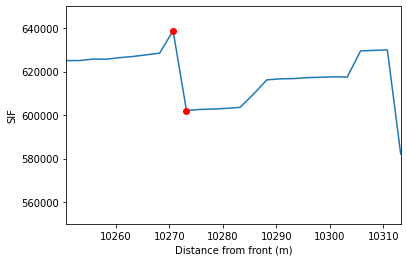

In [4]:
# The code to calculate swell sifs has been moved to run_crevasse_simulations.py

with open('test-10000-to-11000-96-cores.pkl','rb') as f:
    output_1000 = pickle.load(f)

plt.subplots()
plt.plot(Lcs_swell_1000,np.array(output_1000)[:,1])
plt.xlim([Lcs_swell_1000[100],Lcs_swell_1000[125]])
plt.ylim([550e3,650e3])
plt.ylabel('SIF')
plt.xlabel('Distance from front (m)')

crevasse_locations = (Lcs_swell_1000[108],Lcs_swell_1000[109])
questionable_sifs = (np.array(output_1000)[108,1],np.array(output_1000)[109,1])
plt.plot(crevasse_locations,questionable_sifs,'or')

print('Crevasse locations: ')
print(crevasse_locations)
print('SIFs:')
print(questionable_sifs)
print('---')
print('SIF Difference is %f pct over %f m'%(100*np.diff(questionable_sifs)/questionable_sifs[1],
                                         np.diff(crevasse_locations)))

This result was calculated using a specialized, parallelized code.  Let's test the individual components.

First get the result visually, witout calling the dedicated code

In [5]:
phases = np.arange(0,2*np.pi,1)
KI=[[],[]]
KII=[[],[]]

for i,this_Lc in enumerate(crevasse_locations):
    g=geom
    g['Lc'] = this_Lc
    for this_phase in phases:
        print(this_phase)
        these_Ks = c.sif(g,mats,verbose=True,loc='surface', 
                         swell_amplitude=1.0,swell_phase=this_phase)
        KI[i].append(these_Ks[0])
        KII[i].append(these_Ks[1])

0.0
1.0
2.0
3.0
4.0
5.0
6.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0


In [25]:
# Now call the dedicated code
t_start = perf_counter()
test = []
ntest=10
test_locations = np.linspace(10270,10273,ntest)
for x_test in test_locations:
    test.append( c.find_max_phase('surface','I',geom,mats,False,x_test) )
    t_stop = perf_counter()
    print(t_stop-t_start)

46.5290189627558
105.73019993677735
153.1402288991958
200.6733732521534
272.04884920828044
331.74255801178515
426.0849100239575
522.2022962234914
578.9092139713466
635.3076101038605


0
1
2
3
4
5
6
7
8
9
10
11
Crevasse locations: 
(10270.676691729323, 10273.182957393483)
SIFs:
(638782.6010336799, 602078.3775845544)
---
SIF Difference is -6.096253 pct over 2.506266 m


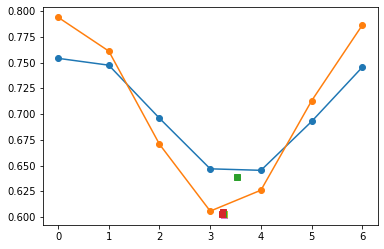

In [21]:
fig,ax1=plt.subplots()
ax1.plot(phases,np.array(KI[0])/1e6,'-o',label='Coarse SIF iteration  @ 10643m')
# ax2 = ax1.twinx()
# ax2.plot(phases,np.array(KII[0])/1e6,'-r')

ax1.plot(phases,np.array(KI[1])/1e6,'-o',label='Coarse SIF iteration  @ 10655m')
# ax2.plot(phases,np.array(KII[1])/1e6,'--r')

for i in np.arange(12):
    ax1.plot(test[i][0],test[i][1]/1e6,'s')
    print(i)


recalculated_sifs=(test_4505[1],test_4510[1])

print('Crevasse locations: ')
print(crevasse_locations)
print('SIFs:')
print(recalculated_sifs)
print('---')
print('SIF Difference is %f pct over %f m'%(100*np.diff(recalculated_sifs)/recalculated_sifs[1],
                                         np.diff(crevasse_locations)))

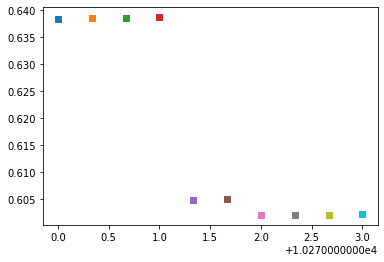

In [27]:
for i in np.arange(ntest):
    plt.plot(test_locations[i],test[i][1]/1e6,'s')

# The function c.find_max_phase() seems to work as intended.
i.e., it is plausible that in the above plot, the squares represent the minima of the two curves.

The problem, however, is that the first plot (fourth cell, above) apparently shows different values at the point 10643m.  That plot shows the value of KI to be near 480e3 but running the calculation directly gives the value near 580e3.

The problem must be in c.call_pmap()

NameError: name 'Lcs_swell' is not defined

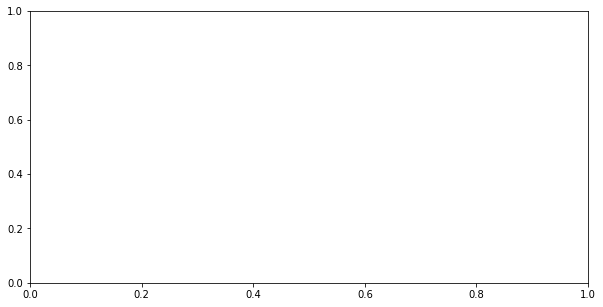

In [8]:
# The code to calculate swell sifs has been moved to run_crevasse_simulations.py

with open('swell-sifs-high-res-linear.pkl', 'rb') as f:
    output = pickle.load(f)
    
with open('test-10635-to-10660-96-cores-192-points.pkl', 'rb') as f:
    output_zoom_96b = pickle.load(f)
    
with open('test-10635-to-10660-96-cores.pkl', 'rb') as f:
    output_zoom_96 = pickle.load(f)
    
with open('test-10000-to-11000-96-cores.pkl','rb') as f:
    output_1000 = pickle.load(f)
    
with open('test-9000-to-11000.pkl','rb') as f:
    output_2000 = pickle.load(f)    
    
with open('test-7000-to-11000.pkl','rb') as f:
    output_4000 = pickle.load(f)    

Lcs_swell_zoom = np.linspace(10635,10660,96)
Lcs_swell_zoom2 = np.linspace(10635,10660,192)
Lcs_swell_100 = np.linspace(10600,10700,192)
Lcs_swell_1000 = np.linspace(10000,11000,400)
Lcs_swell_2000 = np.linspace(9000,11000,400)
Lcs_swell_4000 = np.linspace(7000,11000,400)


plt.subplots(figsize=(10,5))
plt.plot(Lcs_swell,np.array(output[0])[:,1])
plt.plot(Lcs_swell_zoom2,np.array(output_zoom_96b)[:,1],'-')
plt.plot(Lcs_swell_zoom,np.array(output_zoom_96)[:,1],'--')
plt.plot(Lcs_swell_1000,np.array(output_1000)[:,1],'o',markersize=10)
plt.plot(Lcs_swell_2000,np.array(output_2000)[:,1],'o')
plt.plot(Lcs_swell_4000,np.array(output_4000)[:,1],'-')
plt.xlim([10500,10800])
plt.ylim([450e3,650e3])
plt.ylabel('SIF')
plt.xlabel('Distance from front (m)')

crevasse_locations = (Lcs_swell[4505],Lcs_swell[4510])
questionable_sifs = (np.array(output[0])[4505,1],np.array(output[0])[4510,1])
plt.plot(crevasse_locations,questionable_sifs,'s')

In [ ]:
fig,ax=plt.subplots()
plt.plot(Lcs_swell_1000,np.array(output_1000)[:,1],'ok')
ax2=plt.twinx(ax)
ax2.plot(Lcs_swell_1000,np.array(output_1000)[:,0],'or')
plt.xlim([10500,10800])

In [ ]:
Lcs_swell_1000